### Задание №1.
- Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
- Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
- Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

Перепишем код из методички:

In [1]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [3]:
def mean_squared_error(y_real, y_pred):
    return np.mean((y_real - y_pred) ** 2)

In [4]:
def bias(y, z):
    return - 2 * (z - y)

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=23)

        if len(trees) == 0:
            tree.fit(X_train, y_train)
            trees.append(tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            tree.fit(X_train, bias(y_train, z_train))
            trees.append(tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        
    return trees, train_errors, test_errors

In [6]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

Загрузим датасет:

In [7]:
X, y = load_diabetes(return_X_y=True)

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=23)

Построим графики зависимости ошибки от количества деревьев с разными гиперпараметрами: шаг антиградиента, максимальная глубина дерева:

In [9]:
import matplotlib.pyplot as plt

In [10]:
n_trees = 25
coefs = [1] * n_trees

colors=['r', 'g', 'b', 'm']

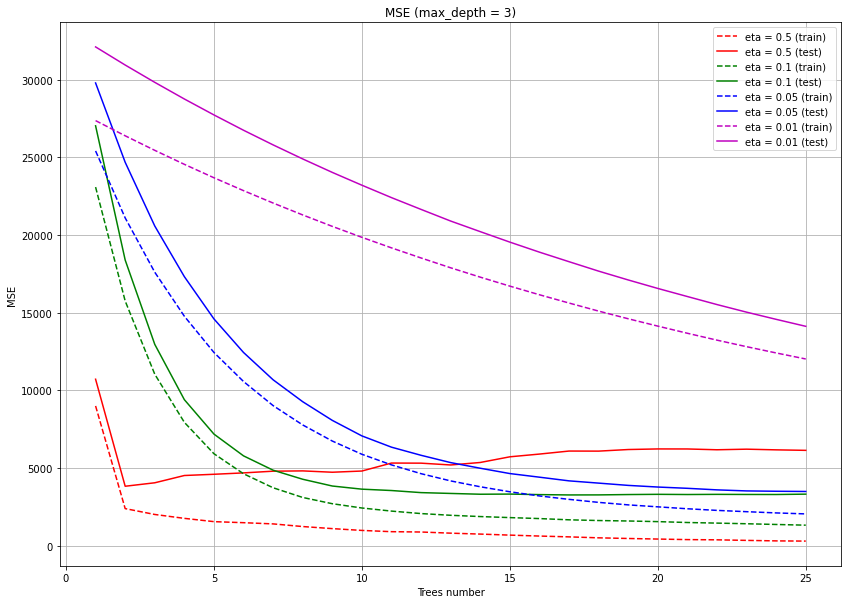

In [11]:
eta_arr = [0.5, 0.1, 0.05, 0.01]
max_depth = 3

plt.figure(figsize=(14, 10))

plt.title(f'MSE (max_depth = {max_depth})')
plt.xlabel('Trees number')
plt.ylabel('MSE')
for c, eta in enumerate(eta_arr):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    plt.plot(np.arange(1, n_trees + 1), train_errors, label=f'eta = {eta} (train)', c=colors[c], ls='--')
    plt.plot(np.arange(1, n_trees + 1), test_errors, label=f'eta = {eta} (test)', c=colors[c], ls='-')
plt.legend()
plt.grid()

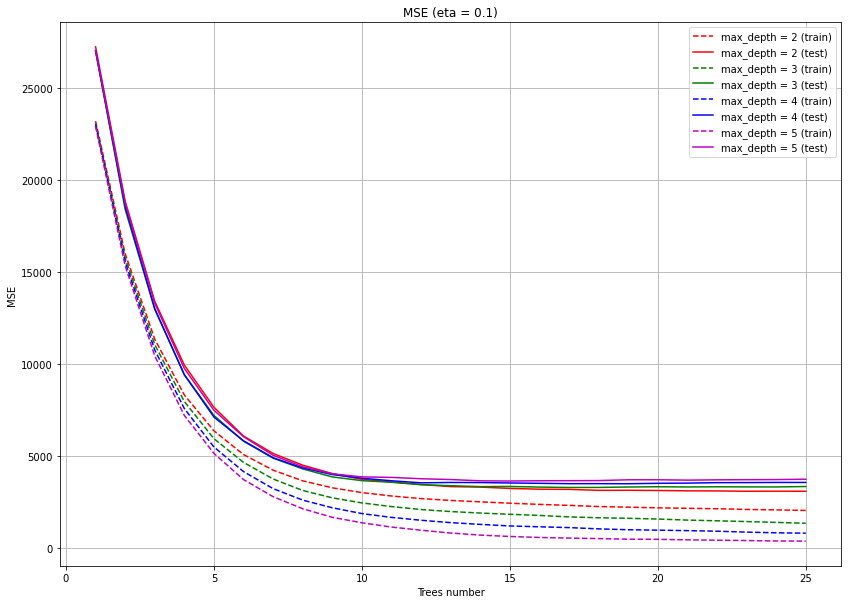

In [12]:
max_depth_arr = [2, 3, 4, 5]
eta = 0.1

plt.figure(figsize=(14, 10))

plt.title(f'MSE (eta = {eta})')
plt.xlabel('Trees number')
plt.ylabel('MSE')
for c, max_depth in enumerate(max_depth_arr):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    plt.plot(np.arange(1, n_trees + 1), train_errors, label=f'max_depth = {max_depth} (train)', c=colors[c], ls='--')
    plt.plot(np.arange(1, n_trees + 1), test_errors, label=f'max_depth = {max_depth} (test)', c=colors[c], ls='-')
plt.legend()
plt.grid()

Как видим из зависимостей: увеличение шага антиградиента до определенного значения увеличивает скорость стремления ошибки к минимальной, в то время как увеличение количества деревьев до определенного значения увеличивает точность алгоритма с уменьшением ошибки. За определенным порогом значений шага антиградиента и количества деревьев алгоритм начинает переобучаться.   
Что касается глубины деревьев, то алгоритм в данном случае показал минимальную ошибку на тесте с max_depth = 2. При увеличении этого значения минимальная ошибка на тесте и разница ошибок на трейне и тесте только росли, то есть алгоритм сильнее подстраивался под обучающую выборку, а на тесте показывал худшие результаты.

Таким образом при оптимальных гиперпараметрах (`eta = 0.1`, `max_depth = 2`, `n_trees = 25`) получим MSE:

In [13]:
n_trees = 25
coefs = [1] * n_trees
eta = 0.1
max_depth = 2

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [14]:
train_prediction = gb_predict(X_train, trees, coefs, eta)

print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

test_prediction = gb_predict(X_test, trees, coefs, eta)

print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

Ошибка алгоритма из 25 деревьев глубиной 2 с шагом 0.1 на тренировочной выборке: 2021
Ошибка алгоритма из 25 деревьев глубиной 2 с шагом 0.1 на тестовой выборке: 3063
